## SpaRTaNS Tutorial: Double Chamber Flow
#### Last updated: 04/30/2022

## Mesh Properties

#### Source Code

In [30]:
Needs["NDSolve`FEM`"]

visualizeMesh[mesh_] := 
 With[{n = Length[mesh["BoundaryElementMarkerUnion"]]},
  Echo[ColorData["BrightBands"] /@ Rest[Subdivide[n]]];
  mesh["Wireframe"[
    "MeshElementStyle" -> 
     Directive @@@ 
      Thread[{FaceForm@*ColorData["BrightBands"] /@ 
         Rest[Subdivide[n]], EdgeForm[None]}],
    Lighting -> "Neutral",
    Axes -> True, Boxed -> True, AxesLabel -> {"x", "y", "z"}]]
  ]
  
splitLine[{point1_, point2_}, zBottom_ : -25., zMiddle_ : -0., zTop_ : 25.] :=
 Block[{pt1, pt2},
  {pt1, pt2} = SortBy[{point1, point2}, First];
  {
   {Append[pt1, zBottom], Append[pt2, zBottom], 
    Append[pt1, zMiddle]},
   {Append[pt1, zMiddle], Append[pt2, zMiddle], 
    Append[pt2, zBottom]},
   {Append[pt1, zMiddle], Append[pt2, zMiddle], Append[pt1, zTop]},
   {Append[pt1, zTop], Append[pt2, zTop], Append[pt2, zMiddle]}
   }
  ]

#### Mesh Properties

- Manual Boundary Mesh
  - First, define the 2D boundary mesh

-Graphics-
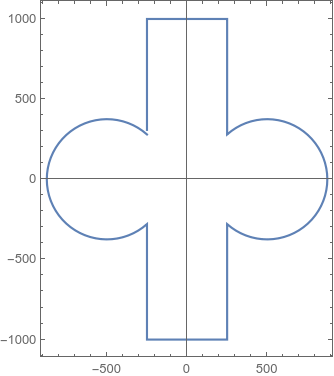

In [34]:
leftChamberChannelIntersection = {x, y} /. FindInstance[
    {x, y} \[Element] 
      Circle[{-500, 0}, 375] &&
     {x, y} \[Element] 
      Line[{{-250, -1000}, {-250, 1000}}]
    , {x, y}, 2];

intersectionAngle = ArcTan @@ (leftChamberChannelIntersection[[2]] - {-500, 0});
leftChamberBoundaryPoints = TranslationTransform[{-500, 0}]@*ScalingTransform[{375, 375}]@*
    AngleVector /@ Subdivide[intersectionAngle, 2 \[Pi] - intersectionAngle, 50];
rightChamberBoundaryPoints = ReflectionTransform[{0, 1}]@*ReflectionTransform[{1, 0}]@
   leftChamberBoundaryPoints;

bottomChannelPoints = DeleteDuplicates[
   Join[Thread[{leftChamberChannelIntersection[[1, 1]], 
      Subdivide[leftChamberChannelIntersection[[1, 2]], -1000, 25]}],
    Thread[{Subdivide[leftChamberChannelIntersection[[1,1]],
    -leftChamberChannelIntersection[[1, 1]], 15], -1000}],
    Thread[{-leftChamberChannelIntersection[[1, 1]], 
      Subdivide[-1000, leftChamberChannelIntersection[[1, 2]], 25]}]
    ]
   ];
topChannelPoints = ReflectionTransform[{1, 0}]@*ReflectionTransform[{0, 1}]@
   bottomChannelPoints;

allPoints = DeleteDuplicates[Join @@ {leftChamberBoundaryPoints, bottomChannelPoints, 
     rightChamberBoundaryPoints, topChannelPoints}];
ListLinePlot[allPoints, AspectRatio -> Automatic, ImageSize -> 250, Frame -> True]

- Then, define a 2D element mesh of order 1

In [42]:
bmesh["middle"] = ToBoundaryMesh[
 "Coordinates" -> allPoints, 
 "BoundaryElements" -> {LineElement[Partition[Append[Range[Length[allPoints]], 1], 2, 1]]}];
emesh["middle"] = ToElementMesh[
 bmesh["middle"], "MeshOrder" -> 1, "MaxCellMeasure" -> {"Length" -> 50}, 
"SteinerPoints" -> False, AccuracyGoal -> 1];

- And now "extrude" it
  - First, gather all boundary points

In [44]:
coords["middle"] = emesh["middle"]["Coordinates"];
boundaryCoords["middle"] = Extract[coords["middle"], 
   List /@ (Flatten[emesh["middle"]["BoundaryElements"][[1, 1]]] //Union)];
boundaryPts = Join[
   ArrayPad[coords["middle"], {{0, 0}, {0, 1}}, -25.],
   ArrayPad[boundaryCoords["middle"], {{0, 0}, {0, 1}}, 0.],
   ArrayPad[coords["middle"], {{0, 0}, {0, 1}}, 25.]
   ];
boundaryPtsAsc = AssociationThread[boundaryPts -> Range[Length[boundaryPts]]];

   - Surfaces

In [48]:
bottomSurfaceTriangles = ArrayPad[Extract[coords["middle"], 
 List /@ emesh["middle"]["MeshElements"][[1, 1]]], {{0, 0}, {0, 0}, {0, 1}}, -25.];
topSurfaceTriangles = ArrayPad[Extract[coords["middle"], 
 List /@ emesh["middle"]["MeshElements"][[1, 1]]], {{0, 0}, {0, 0}, {0, 1}}, 25.];
sideSurfaceTriangles = Join @@ (splitLine[coords["middle"][[#]]] & /@ 
 emesh["middle"]["BoundaryElements"][[1, 1]]);
allSurfaceTriangles = Join[bottomSurfaceTriangles, sideSurfaceTriangles, topSurfaceTriangles];
allSurfaceTriangleIndices = Lookup[boundaryPtsAsc, #] & /@ allSurfaceTriangles;

  - Putting everything together

ElementMesh[{{-875., 875.}, {-1000., 1000.}, {-25., 25.}}, {TetrahedronElement[<16395>]}]
-Graphics3D-
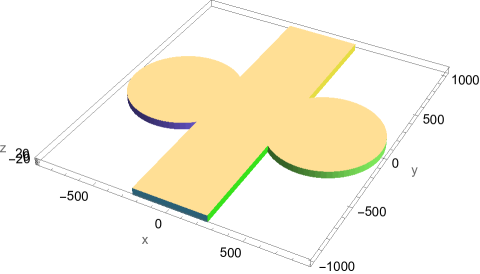

In [53]:
bmesh["SO2"]["double-chamber"] = ToBoundaryMesh[
 "Coordinates" -> boundaryPts, 
"BoundaryElements" -> {TriangleElement[allSurfaceTriangleIndices]}];
mesh["SO2"]["double-chamber"] =  ToElementMesh[
 bmesh["SO2"]["double-chamber"], "MeshOrder" -> 1, "MaxCellMeasure" -> {"Length" -> 50}, 
 "SteinerPoints" -> False, AccuracyGoal -> 1]
visualizeMesh[mesh["SO2"]["double-chamber"]]//QuietEcho